# Code to make Figure 6 
- Maps of correlation between SOM frequency and heat flux through the mixed layer
- Notebook by Alice DuVivier (NCAR)
- June 2023

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as cls
import cartopy
import cartopy.crs as ccrs
from itertools import product
import pickle
import utils
import cmocean
import xskillscore as xs
from minisom import MiniSom, asymptotic_decay

## Specify "winning" SOM parameters

In [2]:
# set paired values for possible winning maps based on Sammon maps
vars_in          = ['aice_d']  # training dataset
som_grid_rows    = [3]    # (y-axis)
som_grid_cols    = [3]    # (x-axis)
sigs             = [1.0]
lrs              = [0.005]
nitrs            = [100000]
ranks            = [9]

In [3]:
# MANUAL CHANGING REQUIRED HERE
n = 0
var_in = vars_in[n]
som_row = som_grid_rows[n]
som_col = som_grid_cols[n]
sig = sigs[n]
lr = lrs[n]
n_iter = nitrs[n]
rank = ranks[n]

In [4]:
# set the location of the already extracted training data
path_in = '/glade/p/cgd/ppc/duvivier/cesm2_antarctic_polynya/SOM_analysis/analysis/Ross_analysis_v5/'
path_out = path_in+'figure_code/final_figures/'
# set shape files info
fname= '/glade/p/cgd/ppc/duvivier/cesm2_antarctic_polynya/SOM_analysis/analysis/Ross_analysis_v4/USNIC_ANTARC_shelf_2022/USNIC_ANTARC_shelf_2022.shp' 

In [5]:
# construct the input name from this, set as output for figure names
fin = 'som_Ross_'+var_in+'_'+str(som_row)+'x'+str(som_col)+'_rank_'+str(rank)+'_sig'+str(sig)+'_lr'+str(lr)+'_iter'+str(n_iter)
print(fin)

som_Ross_aice_d_3x3_rank_9_sig1.0_lr0.005_iter100000


### Load training data to interpret SOM

In [6]:
def normalize_data(data):
    """
    Function for normalizing data prior to training using z-score
    """
    return (data - np.nanmean(data)) / np.nanstd(data)

In [7]:
# open file saved in earlier notebook (soms_antarctica-gettingdata.ipynb)
subset = xr.open_dataset(path_in+'training_data_region_Ross_'+var_in+'.nc')

# assign to numpy array object
subsetarray = subset['train_data'].values

# set data
data = normalize_data(subsetarray)

# set data input length
input_length = subsetarray.shape[1]    # using preprocessed data array; Number of the elements of the vectors in input.


### Load Pickle with winning combos

In [8]:
# open pickle
with open(path_in+'/pickles/'+fin+'.p', 'rb') as infile:
    som = pickle.load(infile)

In [9]:
# double check qerror
qerr = som.quantization_error(data)
print('quantization error: '+str(qerr))

quantization error: 5.796123268140545


In [10]:
# create an empty dictionary using the rows and columns of SOM
keys = [i for i in product(range(som_row),range(som_col))]
winmap = {key: [] for key in keys}

In [11]:
# set frequencies
frequencies = 100.*((som.activation_response(data))/sum(sum(som.activation_response(data))))
#verify the total frequency is 100%
total = sum(sum(frequencies))

# grab the indices for the data within the SOM lattice
for i, x in enumerate(data):
    winmap[som.winner(x)].append(i) 

# create list of the dictionary keys
som_keys = list(winmap.keys())
print(f"Number of composite maps: {len(som_keys)}")
print(f"The rows and columns of the SOM lattice to use to grab SOM indexes:\n{[i for i in list(winmap.keys())]}")

Number of composite maps: 9
The rows and columns of the SOM lattice to use to grab SOM indexes:
[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]


### Calculate the frequency of each node by ensemble and year

In [12]:
# make a list of the members we kept from the training data notebook
members_keep = ['r1i1001p1f1', 'r1i1231p1f1', 'r1i1251p1f1', 'r1i1281p1f1', 'r1i1301p1f1',
                'r3i1041p1f1', 'r3i1231p1f1', 'r3i1251p1f1', 'r3i1281p1f1', 'r3i1301p1f1',
                'r5i1081p1f1', 'r5i1231p1f1', 'r5i1251p1f1', 'r5i1281p1f1', 'r5i1301p1f1',
                'r7i1121p1f1', 'r7i1231p1f1', 'r7i1251p1f1', 'r7i1281p1f1', 'r7i1301p1f1',
                'r9i1161p1f1', 'r9i1231p1f1', 'r9i1251p1f1', 'r9i1281p1f1', 'r9i1301p1f1']

members = list(range(0,len(members_keep),1))

In [13]:
# make a list of all years to loop through
# keep just years greater than 1980 and less than 2080 
yy_st = 1980
yy_ed = 2080

yy_all = list(range(yy_st, yy_ed+1,1))

In [14]:
# make a list of all the nodes
nodes = list(range(0,len(som_keys),1))

In [15]:
# make numpy arrays to fill with frequencies
node_freq_array = np.zeros([len(som_keys),len(members),len(yy_all)])

## loop through each node
for map_num in nodes:
    print('getting frequencies for node '+str(map_num))
    # get indices of training data that mapped to this node
    inds = winmap[som_keys[map_num]]
    # calculate total frequency of this node over all time
    freq = 100.*(len(inds)/len(subset.time))
    # data subset for just this node
    ds_sub_1 = subset.isel(training_times=inds)
    ds_sub_1.load()
    
    ## loop through each year
    for yy in yy_all:
        #print('Getting frequencies for '+str(yy)+'s')
        if yy == 1980:
            y_count = 0
        else:
            y_count = y_count+1  
        # data subset for this year
        ds_sub_2 = ds_sub_1.isel(training_times = ds_sub_1.time.dt.year.isin([yy]))
        ds_sub_2.load()
    
        ## loop through each member
        for mm in members:
            member_id = members_keep[mm]
            #print('Getting frequencies for '+str(member_id)+'s')
            # data subset for this member
            ds_sub_3 = ds_sub_2.where(ds_sub_2.member_id == member_id, drop = True)
            ds_sub_3.load()
            
            # count total times for this node, this member, this year 
            tot = len(ds_sub_3.training_times)
            # only procede if number is not zero
            if tot > 0:
                # now calculate  frequency over winter. Note that there
                # are a total of 92 days per winter (JAS = 31+31+30)
                freq = 100*(tot/92)
            else:
                freq = 0
            # put this frequency into the array
            node_freq_array[map_num, mm, y_count] = freq


getting frequencies for node 0
getting frequencies for node 1
getting frequencies for node 2
getting frequencies for node 3
getting frequencies for node 4
getting frequencies for node 5
getting frequencies for node 6
getting frequencies for node 7
getting frequencies for node 8


In [16]:
print(node_freq_array.shape)

(9, 25, 101)


In [17]:
# convert the numpy array to a xarray
node_freq_all = xr.DataArray(node_freq_array,dims=('node','member_id','year'))

In [18]:
# set coordinate arrays
node_freq_all['node'] = nodes
node_freq_all['member_id'] = members_keep
node_freq_all['year'] = yy_all

In [19]:
# test that frequencies are equal to 100 for any year and member
node_freq_all.isel(member_id=3,year=3).sum(dim='node')

<xarray.DataArray ()>
array(100.)
Coordinates:
    member_id  <U11 'r1i1281p1f1'
    year       int64 1983

### Specify variables to plot

In [60]:
# set path to the pulled data
# Note data is for larger area than only training points
# this data has been processed all the same 'time' coordinates as training data
data_path_in = '/glade/p/cgd/ppc/duvivier/cesm2_antarctic_polynya/SOM_analysis/DATA/data_for_composites/'

var_in = 'HFL_HMXL_hist'

In [61]:
# file name for training variable only here 
fin = 'HMXL_HFLX_ensmembers_timeseries_RossSea'

In [62]:
# load data
ds = xr.open_mfdataset(data_path_in+fin+'.nc')

In [63]:
# Keep just the heat flux through mixed layer variable
data = ds[var_in]

## Get data format/coordinates the same

 brute force this with numpy and new xarrays because had issues earlier

In [64]:
# make numpy arrays to fill with data
data_array = np.zeros([len(data.member_id),len(data.time),len(data.nlat),len(data.nlon)])

In [65]:
# assign data values
data_array = data.values

In [66]:
print(data_array.shape)

(25, 101, 14, 44)


In [67]:
# convert the numpy array to a xarray
data_all = xr.DataArray(data_array,dims=('member_id','year','nlat','nlon'))

In [68]:
# set coordinate arrays
data_all['member_id'] = members_keep
data_all['year'] = yy_all
data_all['nlat'] = data.nlat
data_all['nlon'] = data.nlon

In [69]:
# Flatten the times and member_id for both datasets
data_stacked = data_all.stack(training_times=("member_id","year"))
node_freq_stacked = node_freq_all.stack(training_times=("member_id","year"))


In [70]:
print(data_stacked.shape)
print(node_freq_stacked.shape)

(14, 44, 2525)
(9, 2525)


In [71]:
data_stacked.training_times

<xarray.DataArray 'training_times' (training_times: 2525)>
array([('r1i1001p1f1', 1980), ('r1i1001p1f1', 1981), ('r1i1001p1f1', 1982),
       ..., ('r9i1301p1f1', 2078), ('r9i1301p1f1', 2079),
       ('r9i1301p1f1', 2080)], dtype=object)
Coordinates:
  * training_times  (training_times) object MultiIndex
  * member_id       (training_times) <U11 'r1i1001p1f1' ... 'r9i1301p1f1'
  * year            (training_times) int64 1980 1981 1982 ... 2078 2079 2080

In [72]:
node_freq_stacked.training_times

<xarray.DataArray 'training_times' (training_times: 2525)>
array([('r1i1001p1f1', 1980), ('r1i1001p1f1', 1981), ('r1i1001p1f1', 1982),
       ..., ('r9i1301p1f1', 2078), ('r9i1301p1f1', 2079),
       ('r9i1301p1f1', 2080)], dtype=object)
Coordinates:
  * training_times  (training_times) object MultiIndex
  * member_id       (training_times) <U11 'r1i1001p1f1' ... 'r9i1301p1f1'
  * year            (training_times) int64 1980 1981 1982 ... 2078 2079 2080

### Now calculate correlation

In [73]:
# make numpy array to fill and specify dimensions we want
corr_array = np.zeros([len(nodes),len(data.nlat),len(data.nlon)])
sig_array = np.zeros([len(nodes),len(data.nlat),len(data.nlon)])

## loop through each node
for nn in nodes:
    print('node: '+str(nn))
    # calculate correlation of frequency of node with HMXL at all points and over time axis
    corr_array[nn,:,:] = xs.pearson_r(data_stacked,node_freq_stacked.isel(node=nn),dim='training_times')
    # calculate significance of the correlation using an rtest
    sig_array[nn,:,:] = xs.pearson_r_eff_p_value(data_stacked,node_freq_stacked.isel(node=nn),dim='training_times')

node: 0
node: 1


/glade/work/duvivier/conda-envs/geo_env2/lib/python3.11/site-packages/xskillscore/core/deterministic.py:462: UserWarning: ['training_times'] is not 'time'. Make sure that you are applying this over a temporal dimension.
  warnings.warn(
/glade/work/duvivier/conda-envs/geo_env2/lib/python3.11/site-packages/xskillscore/core/deterministic.py:462: UserWarning: ['training_times'] is not 'time'. Make sure that you are applying this over a temporal dimension.
  warnings.warn(


node: 2
node: 3
node: 4


/glade/work/duvivier/conda-envs/geo_env2/lib/python3.11/site-packages/xskillscore/core/deterministic.py:462: UserWarning: ['training_times'] is not 'time'. Make sure that you are applying this over a temporal dimension.
  warnings.warn(
/glade/work/duvivier/conda-envs/geo_env2/lib/python3.11/site-packages/xskillscore/core/deterministic.py:462: UserWarning: ['training_times'] is not 'time'. Make sure that you are applying this over a temporal dimension.
  warnings.warn(
/glade/work/duvivier/conda-envs/geo_env2/lib/python3.11/site-packages/xskillscore/core/deterministic.py:462: UserWarning: ['training_times'] is not 'time'. Make sure that you are applying this over a temporal dimension.
  warnings.warn(
/glade/work/duvivier/conda-envs/geo_env2/lib/python3.11/site-packages/xskillscore/core/deterministic.py:462: UserWarning: ['training_times'] is not 'time'. Make sure that you are applying this over a temporal dimension.
  warnings.warn(
/glade/work/duvivier/conda-envs/geo_env2/lib/python3

node: 5
node: 6
node: 7
node: 8


/glade/work/duvivier/conda-envs/geo_env2/lib/python3.11/site-packages/xskillscore/core/deterministic.py:462: UserWarning: ['training_times'] is not 'time'. Make sure that you are applying this over a temporal dimension.
  warnings.warn(
/glade/work/duvivier/conda-envs/geo_env2/lib/python3.11/site-packages/xskillscore/core/deterministic.py:462: UserWarning: ['training_times'] is not 'time'. Make sure that you are applying this over a temporal dimension.
  warnings.warn(


In [74]:
print(corr_array.shape)
print(sig_array.shape)

(9, 14, 44)
(9, 14, 44)


In [75]:
# convert the numpy array to a xarray
corr_all = xr.DataArray(corr_array,dims=('node','nlat','nlon'))
sig_all = xr.DataArray(sig_array,dims=('node','nlat','nlon'))

In [76]:
# set coordinate arrays
corr_all['node'] = nodes
corr_all['nlat'] = data.nlat
corr_all['nlon'] = data.nlon

sig_all['node'] = nodes
sig_all['nlat'] = data.nlat
sig_all['nlon'] = data.nlon

## Actually do plots

In [77]:
# Set plotting limits
lat_max = -72
lat_min = -80
lon_max = 200
lon_min = 160
lon_avg = 190

### Plot SOM nodes

In [78]:
# set some labeling things

# set missing value color
grey_tone = 0.5

# set 95% confidence level
max_thresh_all = 0.05 

# set limits
title_in = 'Correlation'
# node average info
levels_in = np.arange(-1,1.1,0.1)
ticks_in = [-1,-0.5,0,0.5,1]
cmap_in = cmocean.cm.balance

# prefixes
pref_1 = 'c) '
pref_2 = 'd) ' 
pref = 'September Heat Flux at Mixed Layer'

node_labels=['0a','0b','0c','1a','1b','1c','2a','2b','2c']

#### Plot entire SOM all nodes

In [80]:
fout = path_out+'supp_fig_corr_'+var_in

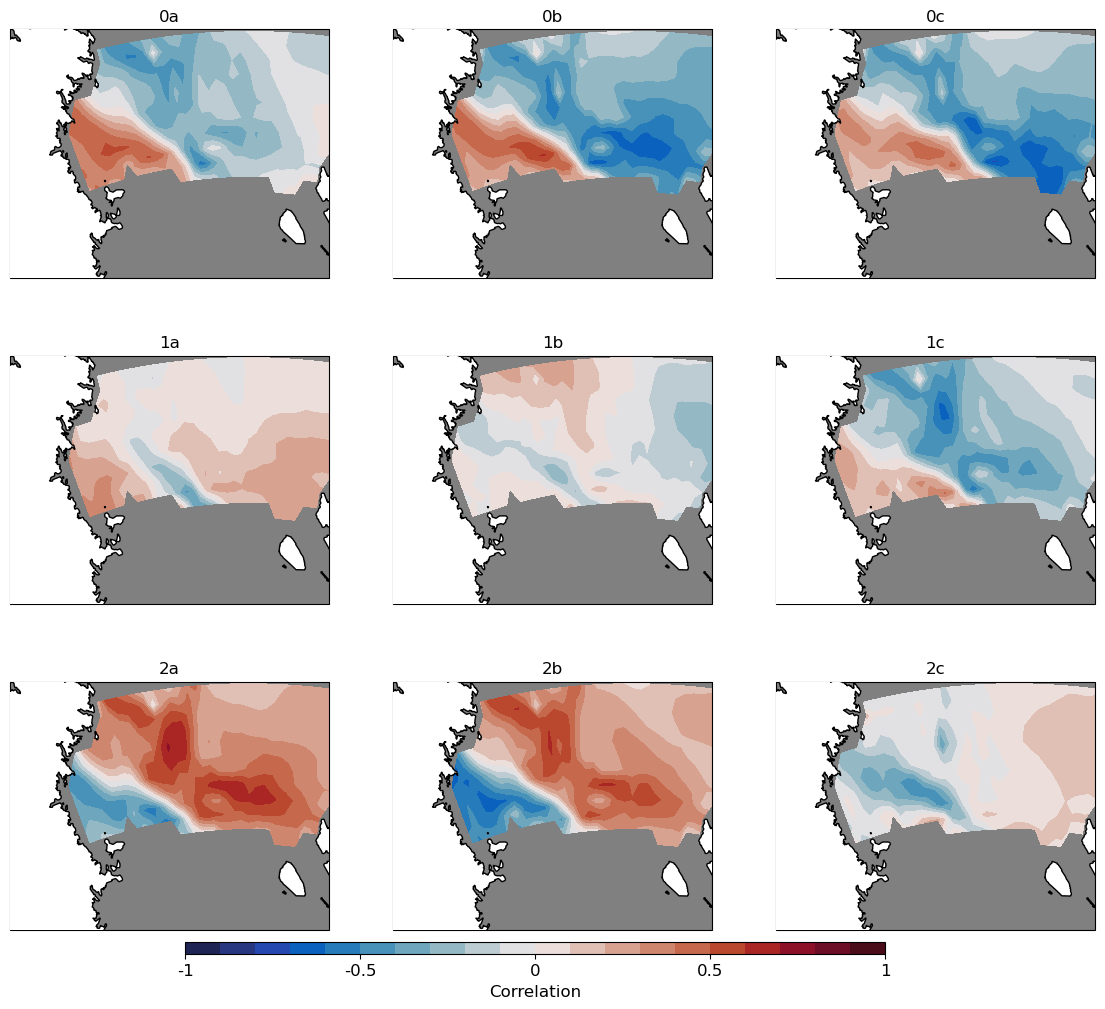

In [82]:
## Plot the composite from *all* data

# get lat/lon
lats = ds.TLAT
lons = ds.TLONG

# set some of the plot info
fig, axs = plt.subplots(som_row, som_col, subplot_kw={'projection':ccrs.Stereographic(central_longitude=lon_avg)}, figsize=(14,12))

# loop through the different maps to get the indices of training data that map there
for map_num in range(len(som_keys)):
    # set face colors
    axs[som_keys[map_num][0],som_keys[map_num][1]].set_facecolor([grey_tone,grey_tone,grey_tone,1])

    ### plot the node composite average
    # grab the data for this decade
    data_temp = corr_all.isel(node=map_num)
    
    # plot
    cs = axs[som_keys[map_num][0],som_keys[map_num][1]].contourf(lons,lats, 
                                                               data_temp,
                                                               transform=ccrs.PlateCarree(),
                                                               cmap = cmap_in,
                                                               levels = levels_in, extend='neither')                                                                
    # set final plot details
    axs[som_keys[map_num][0],som_keys[map_num][1]].set_extent([lon_min,lon_max,lat_min,lat_max])
    axs[som_keys[map_num][0],som_keys[map_num][1]].add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='w')
    axs[som_keys[map_num][0],som_keys[map_num][1]].set_title(node_labels[map_num])
    # Plotting shapefile
    #axs[som_keys[map_num][0],som_keys[map_num][1]].add_geometries(shdf.geometry , ccrs.SouthPolarStereo(central_longitude=lon_avg), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

# colorbar stuff
cbar_ax = fig.add_axes([0.25,0.1,0.5,0.01]) 
cbar = fig.colorbar(cs, cax=cbar_ax, ticks=ticks_in[:], orientation='horizontal', extend='both')
cbar.ax.set_xticklabels(list(ticks_in))
cbar.ax.tick_params(labelsize=12)
cbar.set_label(title_in, fontsize=12)
    
# save figure
plt.savefig(fout, bbox_inches='tight', dpi=200)

#### Plot just contrasting nodes

In [83]:
fout = path_out+'fig_6_corr_'+var_in

/glade/work/duvivier/conda-envs/geo_env2/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1614: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)


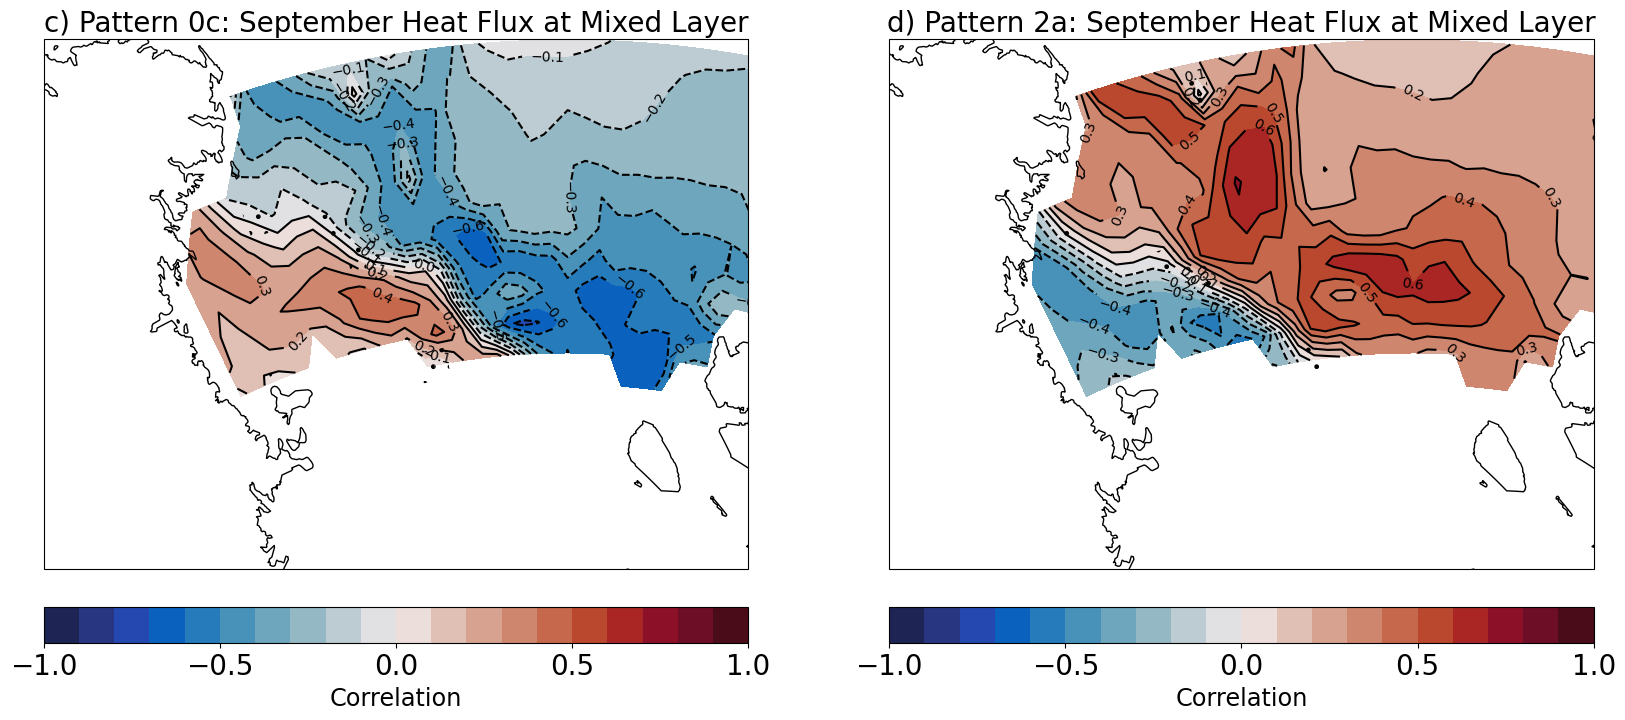

In [84]:
## Plot the composite from only nodes 0c and 2a

# get lat/lon
lats = ds.TLAT
lons = ds.TLONG

# select data
data_temp_1 = corr_all.isel(node=2)
data_temp_2 = corr_all.isel(node=6)
sig_temp_1 = sig_all.isel(node=2)
sig_temp_2 = sig_all.isel(node=6)

# keep only data that is NOT significantly different because we want to stipple NOT significant points
sig_1 = data_temp_1.where(sig_temp_1 >= max_thresh_all)
sig_2 = data_temp_2.where(sig_temp_2 >= max_thresh_all)

# create figure
fig = plt.figure(figsize=(20,10))

# plot the subplots - note it's nrow x ncol x index (starting upper left)
## plot 1
ax = fig.add_subplot(1,2,1, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
this = ax.contourf(lons,lats,
                   data_temp_1,
                   transform=ccrs.PlateCarree(),
                   cmap = cmap_in,
                   levels=levels_in, extend='neither')
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_in,fraction=0.15,pad=0.05)
cbar.ax.tick_params(labelsize=20)
cbar.set_label(title_in, fontsize='xx-large')
# add contours overtop
this2 = ax.contour(lons,lats,
                   data_temp_1,
                   transform=ccrs.PlateCarree(),
                   colors = 'black',
                   levels=levels_in,extend='neither',linewidth=0.1)
plt.clabel(this2,colors='black',inline=1,fontsize=10,levels=levels_in)
# add significance overtop - stippling where it is NOT significant
this3 = ax.pcolor(lons,lats,
                  sig_1,
                  transform=ccrs.PlateCarree(),
                  hatch='.',
                  alpha= 0)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='none')
# Plotting shapefile
#ax.add_geometries(shdf.geometry , ccrs.SouthPolarStereo(central_longitude=lon_avg), facecolor='none', edgecolor='black',linewidth=1, zorder=10)
plt.title(pref_1+'Pattern 0c: '+pref,fontsize=20)

## plot 2
ax = fig.add_subplot(1,2,2, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
this = ax.contourf(lons,lats,
                   data_temp_2,
                   transform=ccrs.PlateCarree(),
                   cmap = cmap_in,
                   levels=levels_in, extend='neither')
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_in,fraction=0.15,pad=0.05)
cbar.ax.tick_params(labelsize=20)
cbar.set_label(title_in, fontsize='xx-large')
# add contours overtop
this2 = ax.contour(lons,lats,
                   data_temp_2,
                   transform=ccrs.PlateCarree(),
                   colors = 'black',
                   levels=levels_in,extend='neither',linewidth=0.1)
plt.clabel(this2,colors='black',inline=1,fontsize=10,levels=levels_in)
# add significance overtop - stippling where it is NOT significant
this3 = ax.pcolor(lons,lats,
                  sig_2,
                  transform=ccrs.PlateCarree(),
                  hatch='.',
                  alpha= 0)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='none')
# Plotting shapefile
#ax.add_geometries(shdf.geometry , ccrs.SouthPolarStereo(central_longitude=lon_avg), facecolor='none', edgecolor='black',linewidth=1, zorder=10)
plt.title(pref_2+'Pattern 2a: '+pref,fontsize=20)

# Finalize figure and save
#fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)

/glade/work/duvivier/conda-envs/geo_env2/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1614: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)


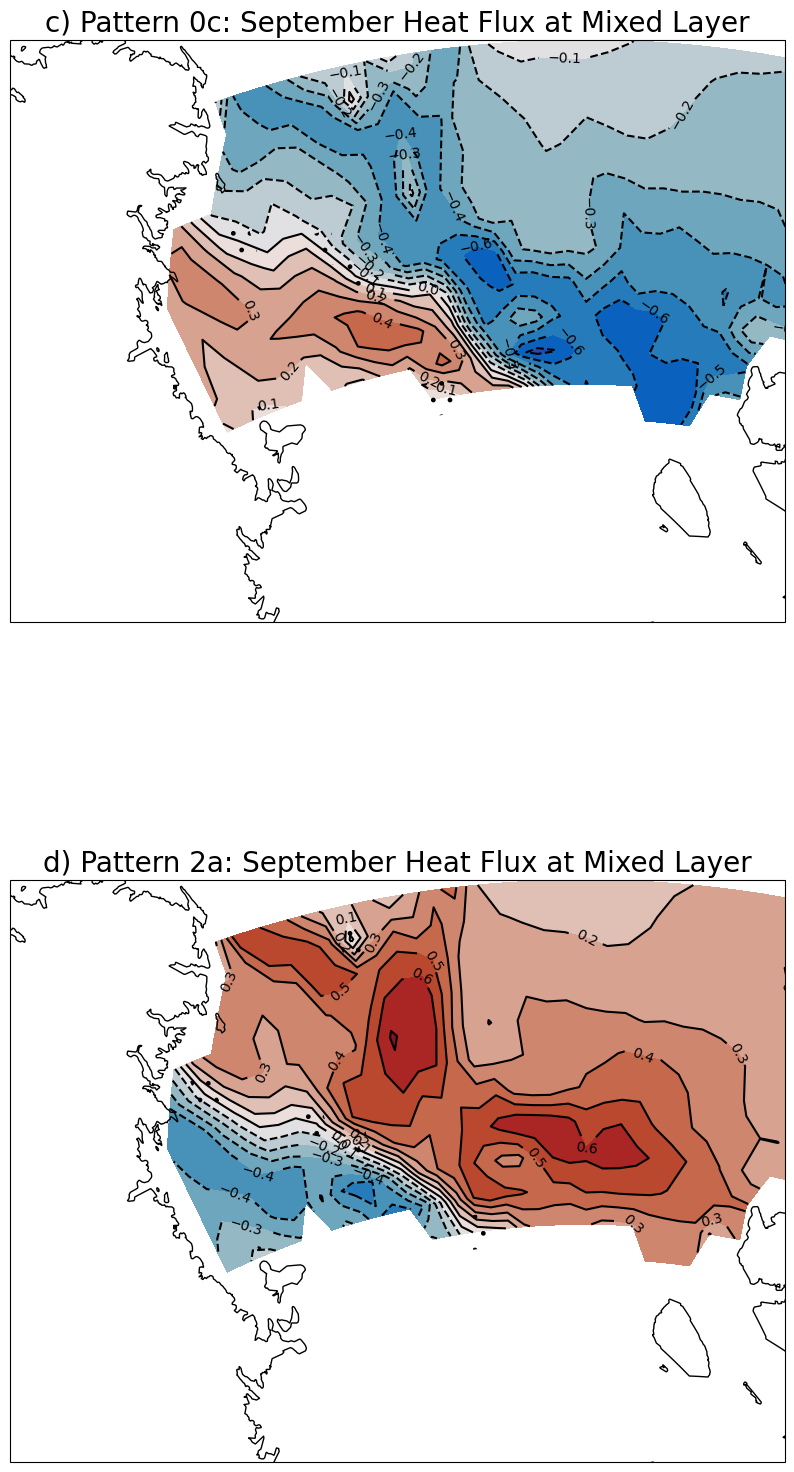

In [87]:
## Plot the composite from only nodes 0c and 2a

# get lat/lon
lats = ds.TLAT
lons = ds.TLONG

# select data
data_temp_1 = corr_all.isel(node=2)
data_temp_2 = corr_all.isel(node=6)
sig_temp_1 = sig_all.isel(node=2)
sig_temp_2 = sig_all.isel(node=6)

# keep only data that is NOT significantly different because we want to stipple NOT significant points
sig_1 = data_temp_1.where(sig_temp_1 >= max_thresh_all)
sig_2 = data_temp_2.where(sig_temp_2 >= max_thresh_all)

# create figure
fig = plt.figure(figsize=(10,20))

# plot the subplots - note it's nrow x ncol x index (starting upper left)
## plot 1
ax = fig.add_subplot(2,1,1, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
this = ax.contourf(lons,lats,
                   data_temp_1,
                   transform=ccrs.PlateCarree(),
                   cmap = cmap_in,
                   levels=levels_in, extend='neither')
#cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_in,fraction=0.15,pad=0.05)
#cbar.ax.tick_params(labelsize=20)
#cbar.set_label(title_in, fontsize='xx-large')
# add contours overtop
this2 = ax.contour(lons,lats,
                   data_temp_1,
                   transform=ccrs.PlateCarree(),
                   colors = 'black',
                   levels=levels_in,extend='neither',linewidth=0.1)
plt.clabel(this2,colors='black',inline=1,fontsize=10,levels=levels_in)
# add significance overtop - stippling where it is NOT significant
this3 = ax.pcolor(lons,lats,
                  sig_1,
                  transform=ccrs.PlateCarree(),
                  hatch='.',
                  alpha= 0)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='none')
# Plotting shapefile
#ax.add_geometries(shdf.geometry , ccrs.SouthPolarStereo(central_longitude=lon_avg), facecolor='none', edgecolor='black',linewidth=1, zorder=10)
plt.title(pref_1+'Pattern 0c: '+pref,fontsize=20)

## plot 2
ax = fig.add_subplot(2,1,2, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
this = ax.contourf(lons,lats,
                   data_temp_2,
                   transform=ccrs.PlateCarree(),
                   cmap = cmap_in,
                   levels=levels_in, extend='neither')
#cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_in,fraction=0.15,pad=0.05)
#cbar.ax.tick_params(labelsize=20)
#cbar.set_label(title_in, fontsize='xx-large')
# add contours overtop
this2 = ax.contour(lons,lats,
                   data_temp_2,
                   transform=ccrs.PlateCarree(),
                   colors = 'black',
                   levels=levels_in,extend='neither',linewidth=0.1)
plt.clabel(this2,colors='black',inline=1,fontsize=10,levels=levels_in)
# add significance overtop - stippling where it is NOT significant
this3 = ax.pcolor(lons,lats,
                  sig_2,
                  transform=ccrs.PlateCarree(),
                  hatch='.',
                  alpha= 0)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='none')
# Plotting shapefile
#ax.add_geometries(shdf.geometry , ccrs.SouthPolarStereo(central_longitude=lon_avg), facecolor='none', edgecolor='black',linewidth=1, zorder=10)
plt.title(pref_2+'Pattern 2a: '+pref,fontsize=20)

# Finalize figure and save
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)

/glade/work/duvivier/conda-envs/geo_env2/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1614: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)


Text(0.5, 1.0, 'd) Pattern 2a: September Heat Flux at Mixed Layer')

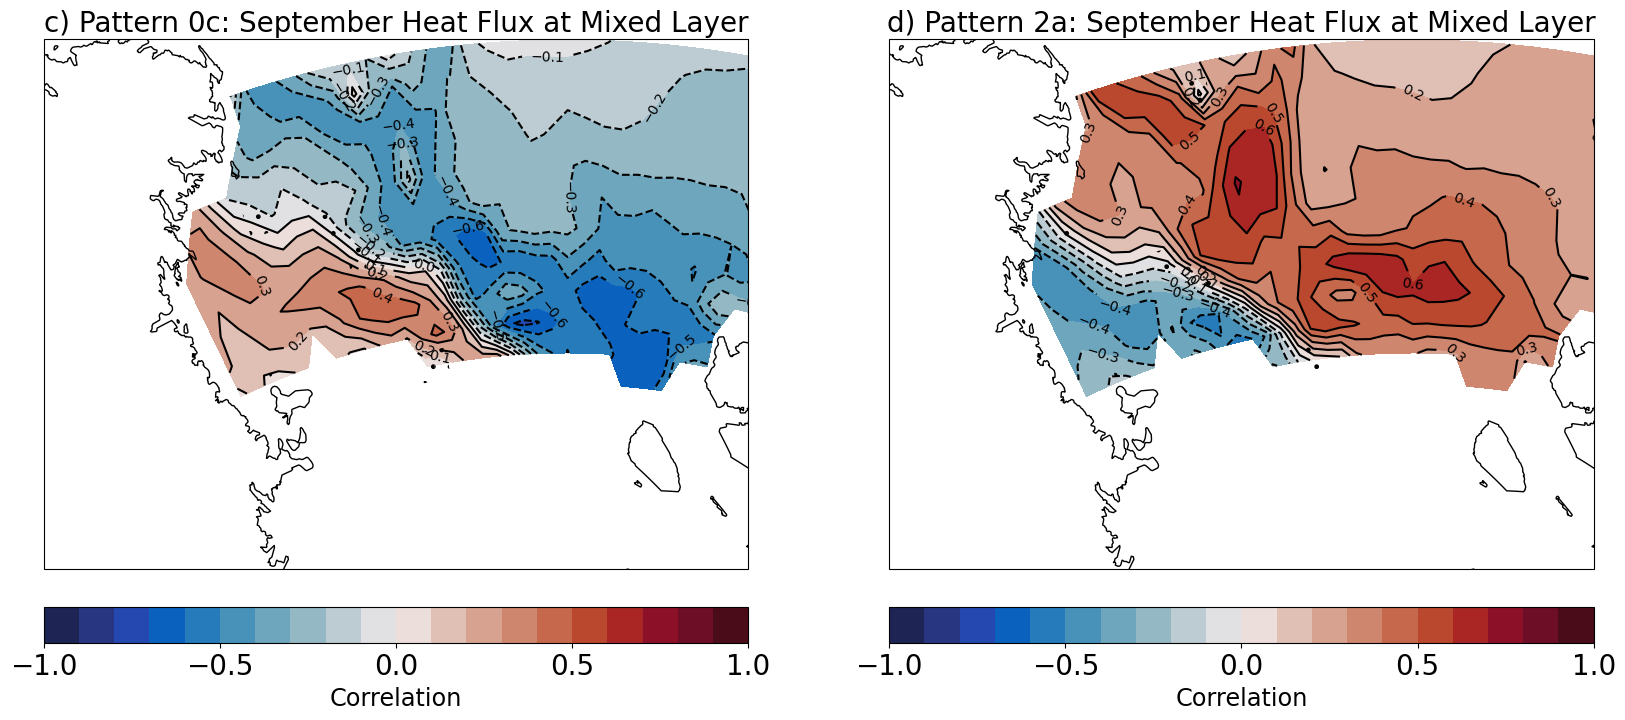

In [88]:
## Plot the colorbar for plot

# get lat/lon
lats = ds.TLAT
lons = ds.TLONG

# select data
data_temp_1 = corr_all.isel(node=2)
data_temp_2 = corr_all.isel(node=6)
sig_temp_1 = sig_all.isel(node=2)
sig_temp_2 = sig_all.isel(node=6)

# keep only data that is NOT significantly different because we want to stipple NOT significant points
sig_1 = data_temp_1.where(sig_temp_1 >= max_thresh_all)
sig_2 = data_temp_2.where(sig_temp_2 >= max_thresh_all)

# create figure
fig = plt.figure(figsize=(20,10))
fout = 'fig_6_colorbar'

# plot the subplots - note it's nrow x ncol x index (starting upper left)
## plot 1
ax = fig.add_subplot(1,2,1, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
this = ax.contourf(lons,lats,
                   data_temp_1,
                   transform=ccrs.PlateCarree(),
                   cmap = cmap_in,
                   levels=levels_in, extend='neither')
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_in,fraction=0.15,pad=0.05)
cbar.ax.tick_params(labelsize=20)
cbar.set_label(title_in, fontsize='xx-large')
# add contours overtop
this2 = ax.contour(lons,lats,
                   data_temp_1,
                   transform=ccrs.PlateCarree(),
                   colors = 'black',
                   levels=levels_in,extend='neither',linewidth=0.1)
plt.clabel(this2,colors='black',inline=1,fontsize=10,levels=levels_in)
# add significance overtop - stippling where it is NOT significant
this3 = ax.pcolor(lons,lats,
                  sig_1,
                  transform=ccrs.PlateCarree(),
                  hatch='.',
                  alpha= 0)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='none')
# Plotting shapefile
#ax.add_geometries(shdf.geometry , ccrs.SouthPolarStereo(central_longitude=lon_avg), facecolor='none', edgecolor='black',linewidth=1, zorder=10)
plt.title(pref_1+'Pattern 0c: '+pref,fontsize=20)

## plot 2
ax = fig.add_subplot(1,2,2, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
this = ax.contourf(lons,lats,
                   data_temp_2,
                   transform=ccrs.PlateCarree(),
                   cmap = cmap_in,
                   levels=levels_in, extend='neither')
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_in,fraction=0.15,pad=0.05)
cbar.ax.tick_params(labelsize=20)
cbar.set_label(title_in, fontsize='xx-large')
# add contours overtop
this2 = ax.contour(lons,lats,
                   data_temp_2,
                   transform=ccrs.PlateCarree(),
                   colors = 'black',
                   levels=levels_in,extend='neither',linewidth=0.1)
plt.clabel(this2,colors='black',inline=1,fontsize=10,levels=levels_in)
# add significance overtop - stippling where it is NOT significant
this3 = ax.pcolor(lons,lats,
                  sig_2,
                  transform=ccrs.PlateCarree(),
                  hatch='.',
                  alpha= 0)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='none')
# Plotting shapefile
#ax.add_geometries(shdf.geometry , ccrs.SouthPolarStereo(central_longitude=lon_avg), facecolor='none', edgecolor='black',linewidth=1, zorder=10)
plt.title(pref_2+'Pattern 2a: '+pref,fontsize=20)

# Finalize figure and save
#fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)